# 波士顿房价预测——回归模型

In [1]:
from keras.datasets import boston_housing

Using TensorFlow backend.


In [2]:
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

一共 506 样本，404 训练样本、102 测试样本。

输入数据得每个特征都有不同的取值范围。

In [3]:
train_targets

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4, 12.1,
       17.9, 23.1, 19.9, 15.7,  8.8, 50. , 22.5, 24.1, 27.5, 10.9, 30.8,
       32.9, 24. , 18.5, 13.3, 22.9, 34.7, 16.6, 17.5, 22.3, 16.1, 14.9,
       23.1, 34.9, 25. , 13.9, 13.1, 20.4, 20. , 15.2, 24.7, 22.2, 16.7,
       12.7, 15.6, 18.4, 21. , 30.1, 15.1, 18.7,  9.6, 31.5, 24.8, 19.1,
       22. , 14.5, 11. , 32. , 29.4, 20.3, 24.4, 14.6, 19.5, 14.1, 14.3,
       15.6, 10.5,  6.3, 19.3, 19.3, 13.4, 36.4, 17.8, 13.5, 16.5,  8.3,
       14.3, 16. , 13.4, 28.6, 43.5, 20.2, 22. , 23. , 20.7, 12.5, 48.5,
       14.6, 13.4, 23.7, 50. , 21.7, 39.8, 38.7, 22.2, 34.9, 22.5, 31.1,
       28.7, 46. , 41.7, 21. , 26.6, 15. , 24.4, 13.3, 21.2, 11.7, 21.7,
       19.4, 50. , 22.8, 19.7, 24.7, 36.2, 14.2, 18.9, 18.3, 20.6, 24.6,
       18.2,  8.7, 44. , 10.4, 13.2, 21.2, 37. , 30.7, 22.9, 20. , 19.3,
       31.7, 32. , 23.1, 18.8, 10.9, 50. , 19.6,  5. , 14.4, 19.8, 13.8,
       19.6, 23.9, 24.5, 25. , 19.9, 17.2, 24.6, 13

## 准备数据

**取值范围差异大的数据输入神经网络可能有问题，虽然网络可能自动适应这种数据，但学习变得更加困难。**

普遍的最佳实践是 **对每个特征做标准化**。

In [4]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

测试数据标准化的均值和标准差都是在训练集上计算得到的。

在**工作时，我们不难使用在测试数据上计算得到的任何结果**。

In [7]:
from keras import models
from keras import layers

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

最后一层只有 1 个单元，没有激活，是一个线性层。**这是标量回归的典型设置**。添加激活函数将限制输出范围，而不加限制可以学习预测任意范围的值。

**使用了 mse 均方误差损失函数，使用了 mae 平均绝对误差作为指标（预测值和目标值之差的绝对值）**。

## 使用 K 折交叉验证

使用训练集和验证集的方法如果数据点少，验证会有很大的波动，即存在很大的方差。使用 K 折交叉验证可以有效进行模型评估。

In [18]:
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
all_mae_histories = []  # 保存历史验证结果

for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples : (i+1) * num_val_samples]  # 准备验证集
    val_targets = train_targets[i * num_val_samples : (i+1) * num_val_samples]
    
    partial_train_data = np.concatenate(
    [train_data[:i * num_val_samples],
    train_data[(i+1) * num_val_samples:]],
    axis=0)
    
    partial_train_targets = np.concatenate(
    [train_targets[:i * num_val_samples],
    train_targets[(i+1) * num_val_samples:]],
    axis=0)
    
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                 epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['mae']
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)
    all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [19]:
# 计算平均验证分数
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]
average_mae_history

[10.48447,
 3.5257692,
 2.9714582,
 2.7189512,
 2.5514123,
 2.475666,
 2.3594823,
 2.315384,
 2.2462552,
 2.235702,
 2.2202663,
 2.155049,
 2.0874953,
 2.0979908,
 2.0393937,
 2.0400257,
 2.020128,
 1.9843698,
 1.9922538,
 1.9963324,
 1.9448593,
 1.8991388,
 1.9302739,
 1.8692306,
 1.8583424,
 1.8440199,
 1.8041384,
 1.8297719,
 1.840689,
 1.7933265,
 1.8091142,
 1.7501839,
 1.8144789,
 1.7790906,
 1.7384017,
 1.7657295,
 1.7034676,
 1.7359241,
 1.7339914,
 1.7199978,
 1.6859307,
 1.7011981,
 1.6547073,
 1.6875645,
 1.6412944,
 1.6549675,
 1.6266444,
 1.6290606,
 1.6255157,
 1.6410758,
 1.5992528,
 1.6233399,
 1.6031427,
 1.5670801,
 1.5610486,
 1.582626,
 1.5546911,
 1.5765052,
 1.5327729,
 1.5598674,
 1.5151343,
 1.5130721,
 1.5379618,
 1.5594256,
 1.4814494,
 1.4966831,
 1.4789553,
 1.5030156,
 1.4693561,
 1.4209172,
 1.4866023,
 1.4450192,
 1.447086,
 1.4410788,
 1.4341602,
 1.4110967,
 1.4288795,
 1.4330258,
 1.370323,
 1.43701,
 1.4118072,
 1.4002745,
 1.3646955,
 1.3659713,
 1.4

## 绘制曲线

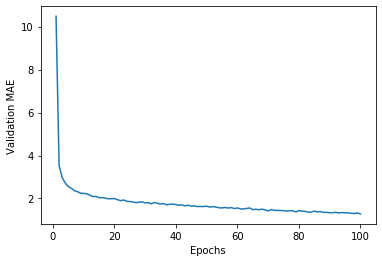

In [21]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [24]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history)

<function matplotlib.pyplot.show(*args, **kw)>

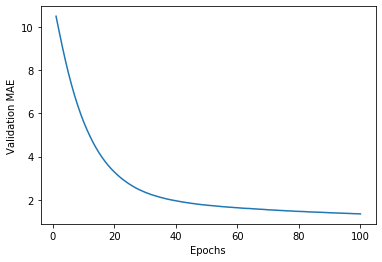

In [25]:
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

## 训练最终模型

完成模型调参之后，我们使用最近参数在所有训练数据上训练最终的生产模型。然后观察在测试集上的性能。

In [26]:
model = build_model()
model.fit(train_data, train_targets,
         epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

102/102 [==============================] - 0s 362us/step


In [27]:
test_mae_score

2.5382440090179443